In [71]:
import os
import sys
sys.path.append("./..")
from cell_graph import Cell_Graph
from utils import reverse_dict
from definitions import get_node_color, get_node_id
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


# Danenberg et al

In [57]:
cells = pd.read_csv('Datasets/Danenberg_et_al/cells.csv') 

### Select an example patient for demonstration

In [58]:
patient_id = 'MB-0002'

In [59]:
cells_ = cells[(cells['metabric_id'] == patient_id)].reset_index(drop=True)
print("Patient id: {}, {} images/cellular graphs, {} cells in the image".format(patient_id, len(cells_['ImageNumber'].unique()), len(cells_)))
cells_.head()

Patient id: MB-0002, 1 images/cellular graphs, 2115 cells in the image


,ImageNumber,ObjectNumber,metabric_id,meta_id,meta_description,print_order,colours,is_epithelial,isTumour,is_normal,...,CD31-vWF,CXCL12,HLA-ABC,panCK,c-Caspase3,DNA1,DNA2,Location_Center_X,Location_Center_Y,AreaShape_Area
0,70,1,MB-0002,SI 15,Endothelial,15,#FFC400,False,True,0,...,0.135851,0.034271,0.426167,0.242375,0.023263,6.556678,12.885264,96.885057,4.425287,87
1,70,2,MB-0002,SI 15,Endothelial,15,#FFC400,False,True,0,...,0.109537,0.131122,0.430658,0.160589,0.027191,7.096300,13.544633,111.500000,5.511111,90
2,70,3,MB-0002,Ep 1,CK8-18^{hi}CXCL12^{hi},1,#00BFFF,True,True,0,...,0.370257,1.054082,0.292244,17.512955,0.295951,35.438408,68.491421,242.684211,8.815789,76
3,70,4,MB-0002,Ep 1,CK8-18^{hi}CXCL12^{hi},1,#00BFFF,True,True,0,...,0.266712,1.121661,0.287368,22.773426,0.292198,36.575089,68.756238,252.554455,6.019802,101
4,70,5,MB-0002,Ep 4,CK^{+} CXCL12^{+},4,#1E90FF,True,True,0,...,0.288839,0.992812,0.315746,16.217944,0.275120,33.418111,63.555175,268.603687,9.069124,217


### Standardize DataFrame column names 

In [60]:
cells_['cellTypeID'] = cells_['meta_description'].map( get_node_id('Danenberg', 'CellType') )

In [61]:
patientID_colname = "metabric_id"
imageID_colname = "ImageNumber"
celltypeID_colname = "cellTypeID"
coorX_colname = "Location_Center_X"
coorY_colname = "Location_Center_Y"
cells_ = cells_.rename(
            columns={
                patientID_colname: "patientID",
                imageID_colname: "imageID",
                celltypeID_colname: "celltypeID",
                coorX_colname: "coorX",
                coorY_colname: "coorY",
            }
        )

### Build cellular graph data using the `Cell_Graph()` class

In [62]:
cell_graph_ = Cell_Graph()
Cell_graphs = cell_graph_.generate(cells_)

In [63]:
print("There are {} patients/cell graphs".format(len(Cell_graphs)))

for i, cell_graph in enumerate(Cell_graphs):
    print("The {} st cell graph is a tuple with 3 elements: (patient_id, graph, cell_types)".format(i+1))
    print("\tThe first element is the patient id： {}".format(cell_graph[0]))
    print("\tThe second element is the adjacnecy matrix, with the shape of {}".format(cell_graph[1].shape))
    print("\tThe third element is the cell types, with the shape of {}".format(cell_graph[2].shape))
    print(
        "There are {} cells with {} unique cell types".format(
            cell_graph[1].shape[0], np.unique(cell_graph[2]).shape[0]
        )
    )


There are 1 patients/cell graphs
The 1 st cell graph is a tuple with 3 elements: (patient_id, graph, cell_types)
	The first element is the patient id： MB-0002
	The second element is the adjacnecy matrix, with the shape of (2115, 2115)
	The third element is the cell types, with the shape of (2115,)
There are 2115 cells with 15 unique cell types


### Plot the cellular graph

In [67]:
def get_pos(G):
    x = nx.get_node_attributes(G, "coorX")
    y = nx.get_node_attributes(G, "coorY")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos

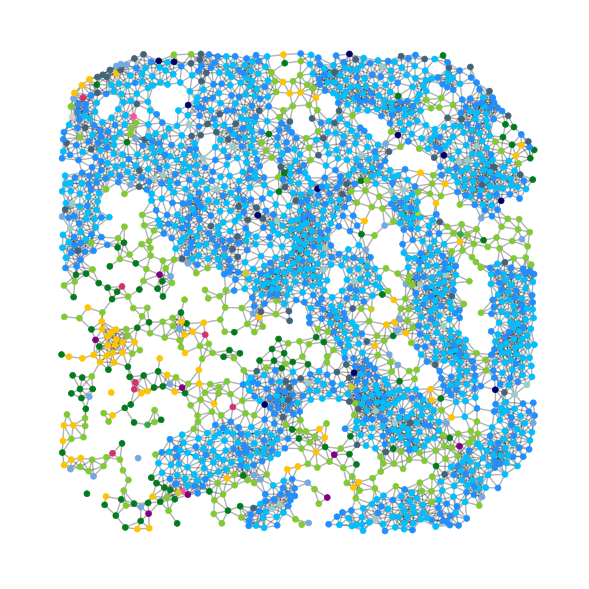

In [70]:
Adj = Cell_graphs[0][1]
# For visualization propose, we set the diagonal of the adjacency matrix to be 0
np.fill_diagonal(Adj, 0)
# For visualization purpose, we only show edges with a weight higher than 0.01
Adj[Adj < 0.01] = 0
G = nx.from_numpy_array(Adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

## Plot the cell type legend

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


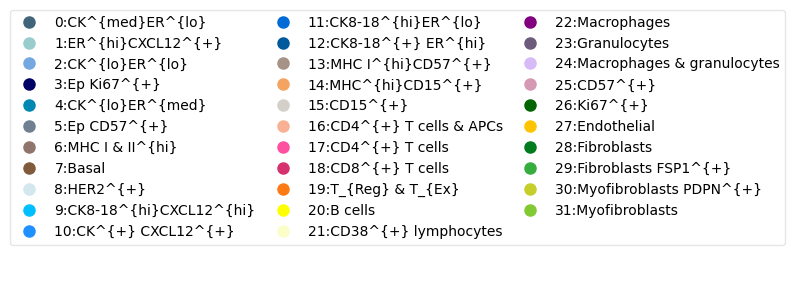

In [72]:
# Print Legend
fig, ax = plt.subplots(figsize=(10, 0.4), tight_layout=True)
func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
cell_types = [
    str(i) + ":" + reverse_dict(get_node_id("Danenberg", 'CellType'))[i]
    for i in range(len(get_node_id("Danenberg", 'CellType')))
]
handles = [
    func("o", get_node_color("Danenberg", 'CellType')[i.split(":")[1]])
    for i in cell_types
]
ax.legend(
    handles,
    cell_types,
    loc=3,
    framealpha=0.5,
    frameon=1,
    ncols=3,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    mode="expand",
    borderaxespad=0.0,
    fontsize=10,
)
ax.axis("off")
plt.show()